## Swwet list taxi - series numéricas

## 1. Preparar datos 

In [1]:
#importar librerias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
#cargar datos en un dataframe
df_taxis = pd.read_csv('/Users/whitneyrios/PYTHON/My projects py/proyecto 13/Sweet-Lift-Taxi--Series-numericas/dataset/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#visualizar los datos
df_taxis.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#viendo la informacion general 
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#verificar valores ausentes 
df_taxis.isna().sum()

num_orders    0
dtype: int64

In [6]:
#verificando descripcion general de los datos
df_taxis.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
#ordenar el indice en orden cronologico
df_taxis = df_taxis.sort_index()

In [8]:
#verificar el rango de fechas de la serie temporal
print(df_taxis.index.min())
print(df_taxis.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Contamos con datos desde el 1 de marzo hasta el 31 de agosto del 2018.

In [9]:
#remuestrar por una hora
data_taxis = df_taxis.resample('1h').sum()

## 2. Análisis de los datos

In [10]:
#examinar la tendencia y estacionalidad de la serie temporal
decomposed = seasonal_decompose(data_taxis)

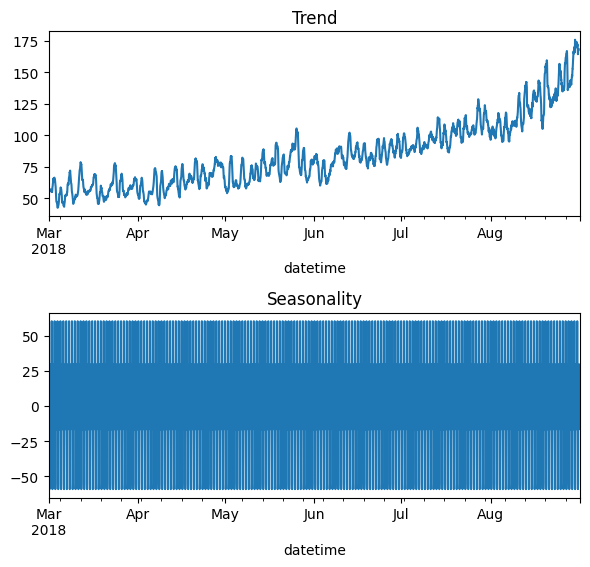

In [11]:
#graficar la tendencia y la estacionalidad de la serie temporal
plt.figure(figsize=(6,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Mediante los gráficos, se aprecia una tendencia ascendente hacia el mes de agosto y se observa un proceso estacionario en la distribución de los datos.

## 3. Entrenamiento del modelo

In [26]:
#crear caracteristicas de calendario y desfase
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek 
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag +1):
       data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) 
    
    return make_features

In [27]:
make_features(data_taxis)


<function __main__.make_features(data)>

<Axes: xlabel='datetime'>

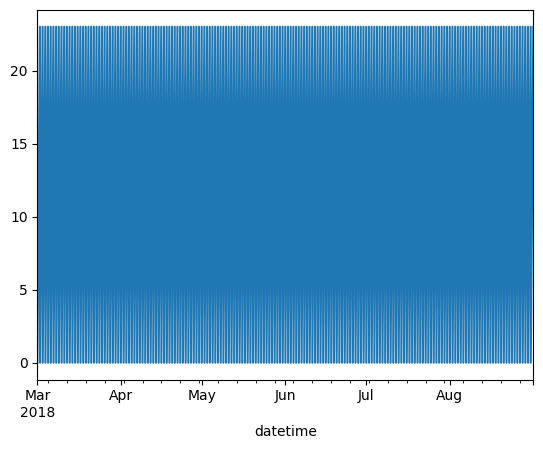

In [16]:
#segmentar los conjuntos de entrenamiento, validacion y prueba



,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
